In [1]:
%matplotlib inline

import os
import gzip
import time
import pickle

import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from IPython.display import clear_output
from datetime import datetime

from lib.utils import make_seed, make_circle_masks
from lib.utils import get_living_mask, get_sobel, softmax, to_rgb
from lib.utils import mnist, cifar10

os.environ["CUDA_VISIBLE_DEVICES"]=""

In [2]:
trains, tests = cifar10("./data/cifar-10")
train_images = trains['data']/255.0
test_images = tests['data']/255.0
train_labels = trains['labels']
test_labels = tests['labels']
label_names = trains['label_names']

print(train_images.shape)
print(test_images.shape)
print(train_labels.shape)
print(test_labels.shape)
print(label_names)
print(np.min(train_images))
print(np.max(train_images))

(50000, 3072)
(10000, 3072)
(50000,)
(10000,)
['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
0.0
1.0


In [3]:
class VAE_encoder(nn.Module):
    
    def __init__(self, dim_out):
        super(VAE_encoder, self).__init__()
        self.conv_mu    = nn.Sequential(nn.Conv2d(3,64,5,padding=2), nn.ReLU(),
                                        nn.Conv2d(64,64,3,padding=1), nn.ReLU(),
                                        nn.Conv2d(64,64,3,padding=1), nn.ReLU(),
                                        nn.MaxPool2d(2,stride=2),
                                        nn.Conv2d(64,128,3,padding=1), nn.ReLU(),
                                        nn.Conv2d(128,128,3,padding=1), nn.ReLU(),
                                        nn.Conv2d(128,128,3,padding=1), nn.ReLU(),
                                        nn.MaxPool2d(2,stride=2),
                                        nn.Conv2d(128,256,3,padding=1), nn.ReLU(),
                                        nn.Conv2d(256,256,3,stride=1,padding=1), nn.ReLU(),
                                        nn.Conv2d(256,512,5,stride=2,padding=2), nn.ReLU(),
                                        nn.Conv2d(512,1024,4))
        self.lin_mu     = nn.Linear(1024,dim_out)
        
    def forward(self, x):
        c_mu = torch.reshape(self.conv_mu(x), [-1,1024])
        return self.lin_mu(c_mu)
    
class VAE_decoder(nn.Module):
    
    def __init__(self, dim_in, dim_out):
        super(VAE_decoder, self).__init__()
        self.lin = nn.Sequential(nn.Linear(dim_in,dim_in*2), nn.ReLU(),
                                 nn.Linear(dim_in*2,dim_in*2), nn.ReLU(),
                                 nn.Linear(dim_in*2,dim_in*2), nn.ReLU(),
                                 nn.Linear(dim_in*2,dim_in*2), nn.ReLU(),
                                 nn.Linear(dim_in*2,dim_out))
        
    def forward(self, z):
        r = self.lin(z)
        return r
    
class GNCAModel(nn.Module):

    def __init__(self, sobels, channel_n, alpha_channel,
                 fire_rate=0.5, calibration=1.0, device=torch.device("cpu")):
        super(GNCAModel, self).__init__()

        self.sobels = sobels
        self.device = device
        self.channel_n = channel_n
        self.alpha_channel = alpha_channel
        
        self.pool = torch.nn.MaxPool2d(kernel_size=3, padding=1, stride=1)

        self.fire_rate = fire_rate
        self.calibration = calibration
        self.to(self.device)

    def perceive(self, x, angle):

        def _perceive_with(x, weight):
            size = weight.shape[0]
            padding = (size-1)/2
            conv_weights = torch.from_numpy(weight.astype(np.float32)).to(self.device)
            conv_weights = conv_weights.view(1,1,size,size).repeat(self.channel_n, 1, 1, 1)
            return F.conv2d(x, conv_weights, padding=int(padding), groups=self.channel_n)

        ys = [x,self.pool(x)]
        for sobel in self.sobels:
            wa_1, wa_2 = get_sobel(sobel)
            wa_1/=np.sum(np.abs(wa_1))
            wa_2/=np.sum(np.abs(wa_2))
            y1 = _perceive_with(x, wa_1)
            y2 = _perceive_with(x, wa_2)
            ys.append(y1)
            ys.append(y2)
        y = torch.cat(ys,1)
        return y
    
    def linear(self, x, w, b=None):
        original_shape = x.size()
        batch = x.size(0)
        y = torch.reshape(x, [batch,-1,original_shape[-1]]).to(self.device)
        if b is None:
            y = torch.bmm(y, w)
        else:
            y = torch.bmm(y, w)+b
        y = torch.reshape(y, list(original_shape[:-1])+[y.size(-1)])
        return y

    def update(self, x, params, fire_rate, angle, gamma=None):
        w0, b0, w1 = params
        
        x = x.transpose(1,3)
        pre_life_mask = get_living_mask(x, self.alpha_channel, 3)

        dx = self.perceive(x, angle)
        dx = dx.transpose(1,3)
        dx = self.linear(dx, w0, b0)
        dx = F.relu(dx)
        dx = self.linear(dx, w1)

        if fire_rate is None:
            fire_rate=self.fire_rate
        stochastic = torch.rand([dx.size(0),dx.size(1),dx.size(2),1])>fire_rate
        stochastic = stochastic.float().to(self.device)
        dx = dx * stochastic
        dx = dx.transpose(1,3)

        if gamma is None:
            x = x+dx
        else:
            x = x+gamma*dx

        post_life_mask = get_living_mask(x, self.alpha_channel, 3)
        life_mask = (pre_life_mask & post_life_mask).float()
        
        x = x * life_mask
        x = x.transpose(1,3)
        return x

    def forward(self, x, params, steps, calibration_map=None, fire_rate=None, gamma=None, angle=0.0):
        history = [x.detach().cpu().clamp(0.0, 1.0).numpy(),]
        for step in range(steps):
            x = self.update(x, params, fire_rate, angle, gamma=gamma)
            if calibration_map is not None:
                h = x[..., :(self.alpha_channel+1)]
                t = calibration_map[..., :(self.alpha_channel+1)]
                _delta = t*(h-1)
                delta = _delta * self.calibration * (calibration_map!=0).float()
                _x = x[..., :(self.alpha_channel+1)]-delta
                x = torch.cat((_x,x[..., (self.alpha_channel+1):]), -1)
            history.append(x.detach().cpu().clamp(0.0, 1.0).numpy())
        return x, history
    
class model_VAE(nn.Module):
    
    def __init__(self, sobels, hidden_encoder, hidden_channel_n, channel_n, map_size, alpha_channel,
                 device=torch.device("cpu")):
        super(model_VAE, self).__init__()
        self.sobels = sobels
        self.channel_n = channel_n
        self.hidden_channel_n = hidden_channel_n
        self.map_size = map_size
        self.alpha_channel = alpha_channel
        self.eps = 1e-3
        self.device = device
        
        self.encoder = VAE_encoder(hidden_encoder).to(self.device)
        self.decoder_w0 = VAE_decoder(hidden_encoder,
                                      channel_n*(len(self.sobels)+1)*2*self.hidden_channel_n).to(self.device)
        self.decoder_b0 = VAE_decoder(hidden_encoder, self.hidden_channel_n).to(self.device)
        self.decoder_w1 = VAE_decoder(hidden_encoder, self.hidden_channel_n*channel_n).to(self.device)
        self.GNCA = GNCAModel(self.sobels, self.channel_n,
                              self.alpha_channel, device=device).to(self.device)
        
        self.to(self.device)
    
    def encode(self, x):
        z = self.encoder(x)
        return z
    
    def decode(self, z):
        w0 = self.decoder_w0(z)
        b0 = self.decoder_b0(z)
        w1 = self.decoder_w1(z)
        params = (torch.reshape(w0,[-1,self.channel_n*(len(self.sobels)+1)*2,self.hidden_channel_n]),
                  torch.reshape(b0,[-1,1,self.hidden_channel_n]),
                  torch.reshape(w1,[-1,self.hidden_channel_n,self.channel_n]))
        return params
    
    def infer(self, x0, x, steps, calibration_map=None):
        with torch.no_grad():
            x_ = torch.reshape(x, [-1,self.alpha_channel,self.map_size[0],self.map_size[1]])
            z = self.encode(x_)
            params = self.decode(z)
            y, history = self.GNCA(x0, params, steps, calibration_map=calibration_map)
            y = y[..., :(self.alpha_channel+1)].clamp(self.eps, 1.0-self.eps)
        return y, history
    
    def ext_infer(self, x0, x, steps, calibration_map=None):
        with torch.no_grad():
            x_ = torch.reshape(x, [-1,self.alpha_channel,self.map_size[0],self.map_size[1]])
            z = self.encode(x_)
            params = self.decode(z)
            y = x0
            start_0 = (x0.size(1)-self.map_size[0])//2
            start_1 = (x0.size(2)-self.map_size[1])//2
            y[:,
              start_0:start_0+self.map_size[0],
              start_1:start_1+self.map_size[1],
              :self.alpha_channel]=x_.transpose(1,2).transpose(2,3)
            history = []
            for i in range(steps):
                y, _ = self.GNCA(y, params, 1, calibration_map=calibration_map)
                y[:,
                  start_0:start_0+self.map_size[0],
                  start_1:start_1+self.map_size[1],
                  :self.alpha_channel]=x_.transpose(1,2).transpose(2,3)
                his = y[..., :(self.alpha_channel+1)].clamp(self.eps, 1.0-self.eps).detach().cpu().numpy()
                history.append(his)
            y = y[..., :(self.alpha_channel+1)].clamp(self.eps, 1.0-self.eps)
        return y, history
    
    def multi_infer(self, x0, xs, steps, gamma=0.99, calibration_map=None):
        with torch.no_grad():
            params_list = []
            zs = []
            for x in xs:
                x_ = torch.reshape(x, [-1,self.alpha_channel,self.map_size[0],self.map_size[1]])
                z = self.encode(x_)
                zs.append(z.detach().cpu().numpy())
                params = self.decode(z)
                params_list.append(params)
            y = x0
            history = [x0.detach().cpu().numpy()]
            for i in range(steps):
                y, _ = self.GNCA(y, params_list[i%len(params_list)], 1, gamma=gamma,
                                 calibration_map=calibration_map)
                his = y[..., :(self.alpha_channel+1)].clamp(self.eps, 1.0-self.eps).detach().cpu().numpy()
                history.append(his)
            y = y[..., :(self.alpha_channel+1)].clamp(self.eps, 1.0-self.eps)
        return y, history, zs
    
    def train(self, x0, x, target, steps, beta, calibration_map=None):
        x_ = torch.reshape(x, [-1,self.alpha_channel,self.map_size[0],self.map_size[1]])
        z = self.encode(x_)
        params = self.decode(z)
        y_raw, _ = self.GNCA(x0, params, steps, calibration_map=calibration_map)
        y_raw = y_raw.clamp(self.eps, 1.0-self.eps)
        y = y_raw[..., :(self.alpha_channel+1)]
        
        mse = F.mse_loss(y, target)
        l2 = torch.sum(torch.pow(z, 2))
        loss = mse + beta*l2
        
        return y_raw, loss, (mse.item(), l2.item())

In [4]:
DEVICE = torch.device("cpu")
model_path = "models/gen_AE_cifar7.pth"
map_size = (32,32)
init_coord = (map_size[0]//2, map_size[1]//2)

SOBEL_SIZES = [3,5]
ALPHA_CHANNEL = 3
HIDDEN_ENCODER = 1024
CHANNEL_N = 16
HIDDEN_CHANNEL_N = 160

BATCH_SIZE = 8
N_STEPS = 128

my_model = model_VAE(SOBEL_SIZES, HIDDEN_ENCODER, HIDDEN_CHANNEL_N, CHANNEL_N,
                     map_size, ALPHA_CHANNEL, device=DEVICE)
if DEVICE == torch.device("cpu"):
    my_model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))
else:
    my_model.load_state_dict(torch.load(model_path))

for param in my_model.parameters():
    param.requires_grad = False

In [5]:
# start_time = time.time()
# seq = np.random.choice(test_images.shape[0], test_images.shape[0], replace=False)
# seq2 = []
# divs = []
# for index in range(len(seq)):
#     time_cost = time.time()-start_time
#     if (index+1)%50==0: print(index+1, "/", len(seq), time_cost/index*(len(seq)-index), "sec left")
#     div = np.sum(((np.expand_dims(test_images[seq[index]],0)-test_images)**2), 1)
#     div[np.argmin(div)] = np.max(div)
#     divs.append(np.min(div))
#     seq2.append(np.argmin(div))

# np.save("cifer_test_seq", seq)
# np.save("cifer_test_divs", divs)
# np.save("cifer_test_seq2", seq2)

seq = np.load("cifer_test_seq.npy")
divs = np.load("cifer_test_divs.npy")
seq2 = np.load("cifer_test_seq2.npy")

In [6]:
print(np.mean(divs), np.sum(divs<50), len(divs))

100.54020179777008 1105 10000


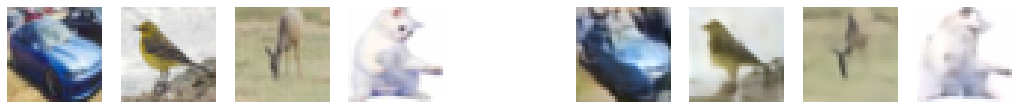

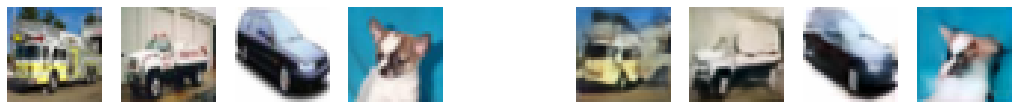

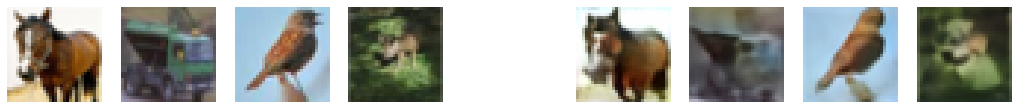

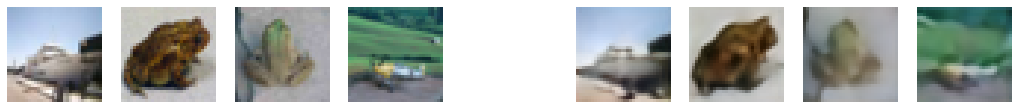

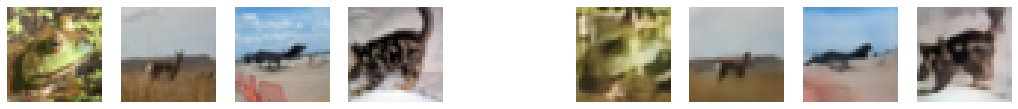

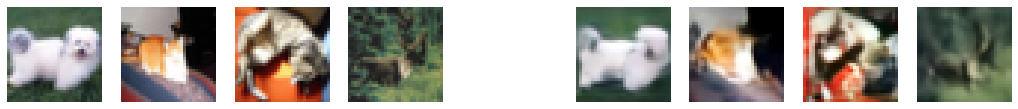

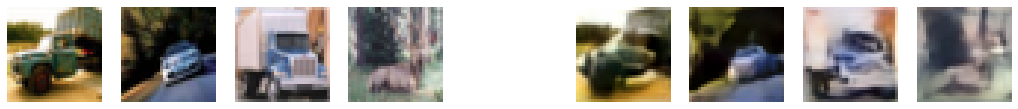

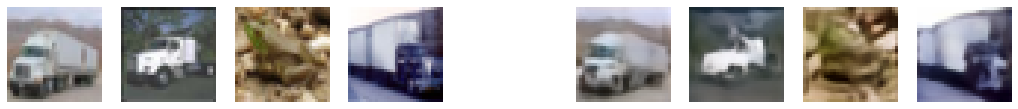

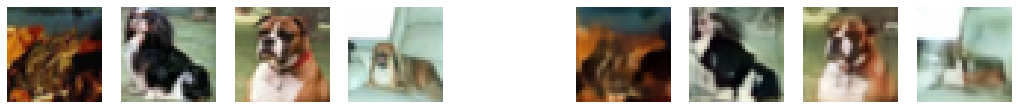

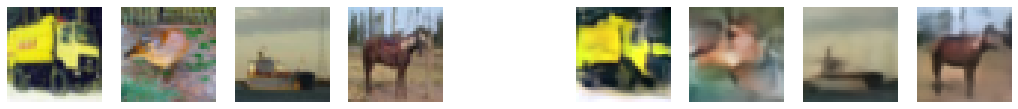

In [11]:
n_batch = 10
map_size = (32,32)
BATCH_SIZE = 4
seq = np.random.choice(test_images.shape[0], test_images.shape[0], replace=False)
for index in range(n_batch):
    indices = seq[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
    x_np = test_images[indices].astype(np.float32)
    x = torch.from_numpy(x_np).to(DEVICE)
    
    target_np = x_np.reshape([-1, ALPHA_CHANNEL, map_size[0], map_size[1]]).transpose([0,2,3,1])
    alpha_values = np.expand_dims(np.ones(target_np.shape[:-1]), -1)
    target_np = np.concatenate([target_np, alpha_values], -1)

    seed = make_seed(map_size, CHANNEL_N, np.arange(CHANNEL_N-ALPHA_CHANNEL)+ALPHA_CHANNEL, init_coord)
    x0_np = np.repeat(seed[None, ...], len(indices), 0)
    x0 = torch.from_numpy(x0_np.astype(np.float32)).to(DEVICE)

    y, history = my_model.infer(x0, x, N_STEPS)
    y = y.detach().cpu().numpy()
    
    plt.figure(figsize=(18,5))
    for i in range(BATCH_SIZE):
        plt.subplot(1,BATCH_SIZE*2+1,i+1)
        plt.imshow(to_rgb(target_np[i]))
        plt.axis('off')
    for i in range(BATCH_SIZE):
        plt.subplot(1,BATCH_SIZE*2+1,BATCH_SIZE+1+i+1)
        plt.imshow(to_rgb(y[i,...,:(ALPHA_CHANNEL+1)]))
        plt.axis('off')
    plt.show()

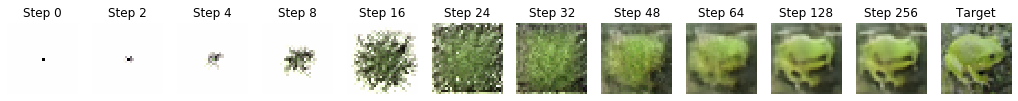

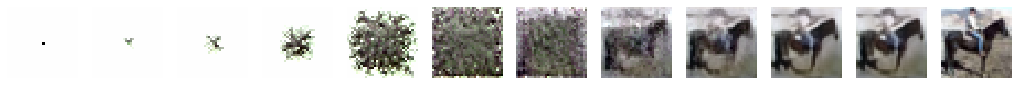

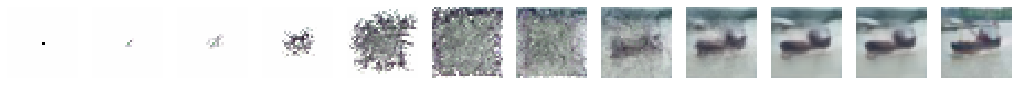

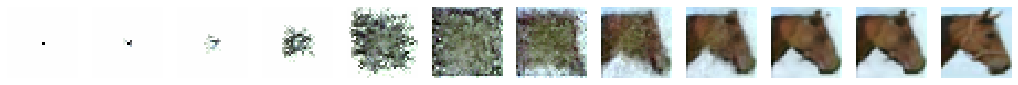

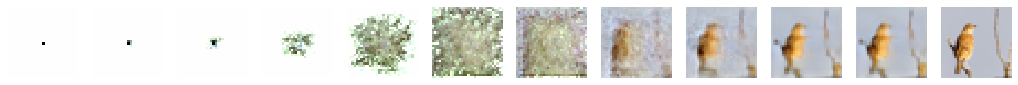

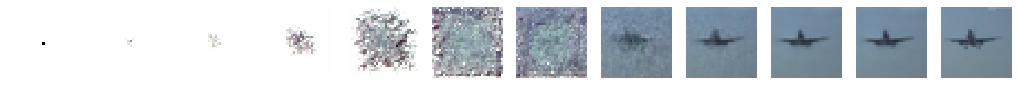

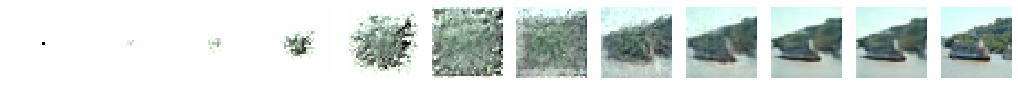

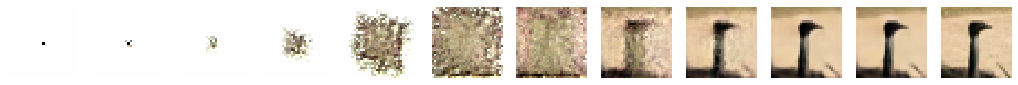

In [53]:
n_batch = 1
BATCH_SIZE = 8
seq = np.random.choice(test_images.shape[0], test_images.shape[0], replace=False)

indices = seq[index*BATCH_SIZE:(index+1)*BATCH_SIZE]
indices = [2149,2234,5257,7003,7023,6644,3079,6323]
# print(indices)
x_np = test_images[indices].astype(np.float32)
x = torch.from_numpy(x_np).to(DEVICE)

target_np = x_np.reshape([-1, ALPHA_CHANNEL, 32, 32]).transpose([0,2,3,1])
alpha_values = np.expand_dims(np.ones(target_np.shape[:-1]), -1)
target_np = np.concatenate([target_np, alpha_values], -1)

seed = make_seed(map_size, CHANNEL_N, np.arange(CHANNEL_N-ALPHA_CHANNEL)+ALPHA_CHANNEL, init_coord)
x0_np = np.repeat(seed[None, ...], len(indices), 0)
x0 = torch.from_numpy(x0_np.astype(np.float32)).to(DEVICE)

y, history = my_model.infer(x0, x, N_STEPS*2)
# y, history = my_model.ext_infer(x0, x, N_STEPS*2)
y = y.detach().cpu().numpy()
    
n_shows = [0,2,4,8,16,24,32,48,64,128,256]

for i_batch in range(history[0].shape[0]):
    plt.figure(figsize=(18,3))
    for i,ii in enumerate(n_shows):
        plt.subplot(1,len(n_shows)+1,i+1)
        plt.imshow(to_rgb(history[ii][i_batch,...,:(ALPHA_CHANNEL+1)]))
        plt.axis('off')
        if i_batch==0:
            plt.gca().set_title("Step "+str(ii))
    plt.subplot(1,len(n_shows)+1,len(n_shows)+1)
    plt.imshow(to_rgb(target_np[i_batch]))
    plt.axis('off')
    if i_batch==0:
        plt.gca().set_title("Target")
    plt.show()